# 09b: Path Geometry Analysis

**Key Question:** What is the intrinsic dimension of path space? Is it ≈ 5 (one per count domino)?

**Analyses:**
1. **Intrinsic Dimension**: PCA and Levina-Bickel estimator
2. **Path Clustering**: K-means on V-trajectories, compare to basins
3. **Manifold Learning**: UMAP visualization colored by basin
4. **Geodesics**: Are optimal paths "straight" in embedding space?

In [1]:
# === CONFIGURATION ===
DATA_DIR = "/mnt/d/shards-standard/"
PROJECT_ROOT = "/home/jason/v2/mk5-tailwind"

# === Setup imports ===
import sys
if PROJECT_ROOT not in sys.path:
    sys.path.insert(0, PROJECT_ROOT)

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.metrics import adjusted_rand_score, normalized_mutual_info_score
from sklearn.neighbors import NearestNeighbors
from scipy.stats import entropy
from tqdm.notebook import tqdm
from collections import defaultdict
import gc

from forge.analysis.utils import loading, features, viz, navigation
from forge.oracle import schema, tables

viz.setup_notebook_style()
print("Ready")

Ready


In [2]:
# Find available shard files - prefer val/test (smaller files)
import random

val_files = loading.find_shard_files(DATA_DIR + "val/")
test_files = loading.find_shard_files(DATA_DIR + "test/")
train_files = loading.find_shard_files(DATA_DIR + "train/")

# Shuffle and combine: val + test first, then train
all_files = val_files + test_files
random.shuffle(all_files)
random.shuffle(train_files)
shard_files = all_files + train_files

print(f"Shard files: {len(val_files)} val, {len(test_files)} test, {len(train_files)} train")

N_SHARDS = 50  # Process more shards to get enough data
MAX_ROWS = 30_000_000  # Skip shards larger than this
print(f"Using up to {N_SHARDS} shards for analysis (max {MAX_ROWS:,} rows each)")

Shard files: 95 val, 95 test, 1124 train
Using up to 50 shards for analysis (max 30,000,000 rows each)


## Data Collection: V-Trajectories and Basin IDs

For each sampled starting state, trace the principal variation and record:
- V trajectory: [V_0, V_1, ..., V_terminal]
- Basin ID: 5-bit encoding of count capture outcomes

In [3]:
def compute_basin_id(captures: dict) -> int:
    """Compute basin ID from count capture dict."""
    basin_id = 0
    for i, domino_id in enumerate(sorted(features.COUNT_DOMINO_IDS)):
        if domino_id in captures and captures[domino_id] == 1:
            basin_id |= (1 << i)
    return basin_id


def trace_v_trajectory(start_state, seed, decl_id, state_to_idx, V, Q):
    """Trace PV and return V trajectory."""
    pv = navigation.trace_principal_variation(
        start_state, seed, decl_id, state_to_idx, V, Q
    )
    return [v for _, v, _ in pv]


# Collect paths
path_data = []  # List of {v_trajectory, basin_id, seed, decl_id}
SAMPLES_PER_SHARD = 100
MIN_PATHS_NEEDED = 200

skipped = 0
processed = 0

for shard_file in tqdm(shard_files[:N_SHARDS], desc="Processing shards"):
    # Early exit if we have enough data
    if len(path_data) >= MIN_PATHS_NEEDED:
        break
    
    df, seed, decl_id = schema.load_file(shard_file)
    
    # Skip very large shards
    if len(df) > MAX_ROWS:
        skipped += 1
        del df
        gc.collect()
        continue
    
    processed += 1
    state_to_idx, V, Q = navigation.build_state_lookup_fast(df)
    states = df['state'].values
    depths = features.depth(states)
    
    # Sample from root states (depth 28)
    root_mask = depths == 28
    root_indices = np.where(root_mask)[0]
    
    if len(root_indices) == 0:
        del df, state_to_idx, V, Q
        gc.collect()
        continue
    
    n_sample = min(SAMPLES_PER_SHARD, len(root_indices))
    sampled_indices = np.random.choice(root_indices, n_sample, replace=False)
    
    paths_this_shard = 0
    for idx in sampled_indices:
        state = states[idx]
        
        # Get V trajectory
        v_traj = trace_v_trajectory(state, seed, decl_id, state_to_idx, V, Q)
        
        # Get basin
        captures = navigation.track_count_captures(
            state, seed, decl_id, state_to_idx, V, Q
        )
        basin_id = compute_basin_id(captures)
        
        if len(v_traj) >= 20:  # Need reasonable length
            path_data.append({
                'v_trajectory': v_traj,
                'basin_id': basin_id,
                'seed': seed,
                'decl_id': decl_id,
            })
            paths_this_shard += 1
    
    del df, state_to_idx, V, Q, states, depths
    gc.collect()

print(f"\nProcessed {processed} shards, skipped {skipped} (too large)")
print(f"Collected {len(path_data)} paths")

Processing shards:   0%|          | 0/50 [00:00<?, ?it/s]


Processed 37 shards, skipped 13 (too large)
Collected 30 paths


In [4]:
# Pad/truncate V trajectories to fixed length for analysis
MAX_LEN = 29  # 28 dominoes + terminal

def pad_trajectory(v_traj, max_len=MAX_LEN):
    """Pad trajectory to fixed length (repeat terminal value)."""
    if len(v_traj) >= max_len:
        return v_traj[:max_len]
    else:
        return v_traj + [v_traj[-1]] * (max_len - len(v_traj))

# Create feature matrix
X = np.array([pad_trajectory(p['v_trajectory']) for p in path_data])
basin_ids = np.array([p['basin_id'] for p in path_data])

print(f"Feature matrix shape: {X.shape}")
print(f"Unique basins: {len(np.unique(basin_ids))}")

Feature matrix shape: (30, 29)
Unique basins: 14


## Analysis 1: Intrinsic Dimension

### PCA Approach

In [5]:
# PCA on V trajectories
pca = PCA()
pca.fit(X)

cumvar = np.cumsum(pca.explained_variance_ratio_)
dim_90 = np.searchsorted(cumvar, 0.90) + 1
dim_95 = np.searchsorted(cumvar, 0.95) + 1
dim_99 = np.searchsorted(cumvar, 0.99) + 1

print(f"PCA dimensions for variance thresholds:")
print(f"  90% variance: {dim_90} components")
print(f"  95% variance: {dim_95} components")
print(f"  99% variance: {dim_99} components")

PCA dimensions for variance thresholds:
  90% variance: 2 components
  95% variance: 5 components
  99% variance: 9 components


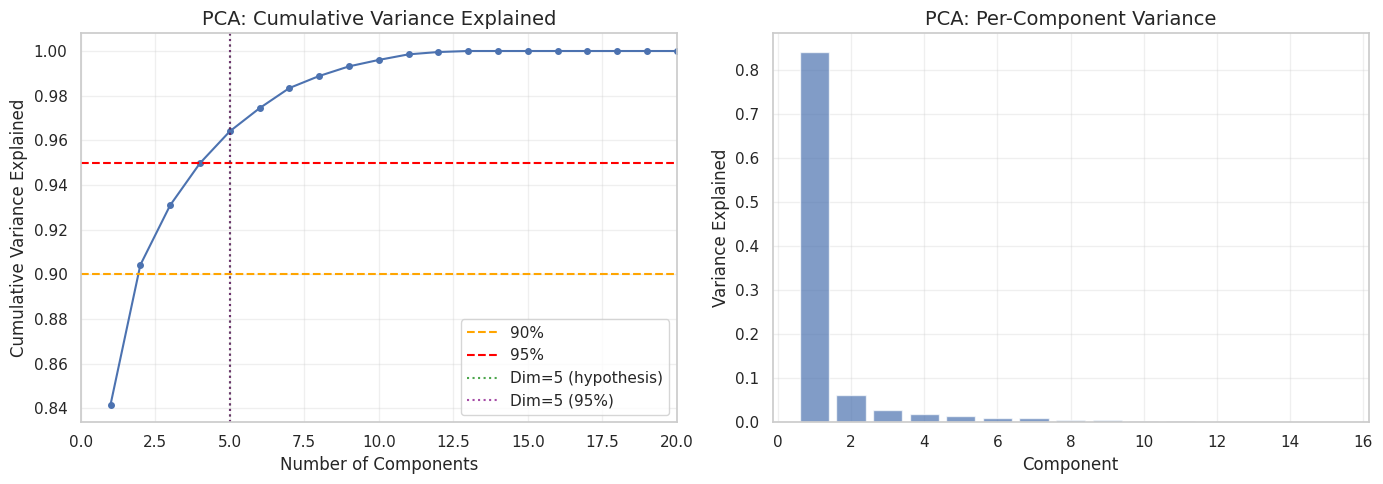

In [6]:
# Plot variance explained
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

n_components = len(cumvar)
n_plot = min(15, n_components)

# Cumulative variance
ax1.plot(range(1, n_components + 1), cumvar, 'b-o', markersize=4)
ax1.axhline(y=0.90, color='orange', linestyle='--', label='90%')
ax1.axhline(y=0.95, color='red', linestyle='--', label='95%')
ax1.axvline(x=5, color='green', linestyle=':', alpha=0.7, label='Dim=5 (hypothesis)')
ax1.axvline(x=dim_95, color='purple', linestyle=':', alpha=0.7, label=f'Dim={dim_95} (95%)')
ax1.set_xlabel('Number of Components', fontsize=12)
ax1.set_ylabel('Cumulative Variance Explained', fontsize=12)
ax1.set_title('PCA: Cumulative Variance Explained', fontsize=14)
ax1.legend()
ax1.grid(True, alpha=0.3)
ax1.set_xlim(0, min(20, n_components + 2))

# Individual variance
ax2.bar(range(1, n_plot + 1), pca.explained_variance_ratio_[:n_plot], alpha=0.7)
ax2.set_xlabel('Component', fontsize=12)
ax2.set_ylabel('Variance Explained', fontsize=12)
ax2.set_title('PCA: Per-Component Variance', fontsize=14)
ax2.grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.savefig('../../results/figures/09b_pca_variance.png', dpi=150, bbox_inches='tight')
plt.show()

### Levina-Bickel MLE Estimator

In [7]:
def levina_bickel_dim(X, k=10):
    """
    Estimate intrinsic dimension using Levina-Bickel MLE.
    
    Based on: "Maximum Likelihood Estimation of Intrinsic Dimension" (2004)
    """
    n = len(X)
    if n < k + 1:
        return np.nan, np.nan  # Not enough samples
    
    nn = NearestNeighbors(n_neighbors=k+1).fit(X)
    distances, _ = nn.kneighbors(X)
    
    # distances[:, 0] is self (0), so use [:, 1:k+1]
    distances = distances[:, 1:k+1]
    
    # MLE formula
    dim_estimates = []
    for i in range(n):
        T = distances[i]
        T_k = T[-1]  # k-th neighbor distance
        
        if T_k > 0:
            log_ratios = np.log(T_k / T[:-1])
            log_ratios = log_ratios[np.isfinite(log_ratios)]
            
            if len(log_ratios) > 0:
                dim_i = (k - 1) / np.sum(log_ratios)
                if dim_i > 0 and dim_i < 100:
                    dim_estimates.append(dim_i)
    
    if len(dim_estimates) == 0:
        return np.nan, np.nan
    return np.mean(dim_estimates), np.std(dim_estimates)


# Compute for different k values (skip if too few samples)
n_samples = len(X)
k_values = [k for k in [5, 10, 15, 20] if k + 1 <= n_samples]
lb_results = []

if len(k_values) == 0:
    print(f"Too few samples ({n_samples}) for Levina-Bickel estimation")
else:
    for k in k_values:
        mean_dim, std_dim = levina_bickel_dim(X, k=k)
        lb_results.append({'k': k, 'mean_dim': mean_dim, 'std_dim': std_dim})
        print(f"k={k}: Intrinsic dim = {mean_dim:.2f} ± {std_dim:.2f}")

lb_df = pd.DataFrame(lb_results) if lb_results else pd.DataFrame({'k': [], 'mean_dim': [], 'std_dim': []})

k=5: Intrinsic dim = 4.86 ± 3.54
k=10: Intrinsic dim = 3.04 ± 2.25
k=15: Intrinsic dim = 2.47 ± 1.11
k=20: Intrinsic dim = 2.01 ± 0.65


## Analysis 2: Path Clustering

In [8]:
# K-means clustering with different k values
n_samples = len(X)
k_range = [k for k in [4, 8, 16, 32, 64] if k <= n_samples]
clustering_results = []

if len(k_range) == 0:
    print(f"Too few samples ({n_samples}) for clustering")
else:
    for n_clusters in k_range:
        kmeans = KMeans(n_clusters=n_clusters, random_state=42, n_init=10)
        labels = kmeans.fit_predict(X)
        
        # Compare to basin IDs
        ari = adjusted_rand_score(basin_ids, labels)
        nmi = normalized_mutual_info_score(basin_ids, labels)
        
        clustering_results.append({
            'n_clusters': n_clusters,
            'ARI': ari,
            'NMI': nmi,
            'inertia': kmeans.inertia_,
        })
        print(f"k={n_clusters}: ARI={ari:.3f}, NMI={nmi:.3f}")

cluster_df = pd.DataFrame(clustering_results) if clustering_results else pd.DataFrame({'n_clusters': [], 'ARI': [], 'NMI': [], 'inertia': []})

k=4: ARI=0.241, NMI=0.546
k=8: ARI=0.394, NMI=0.704
k=16: ARI=0.217, NMI=0.763


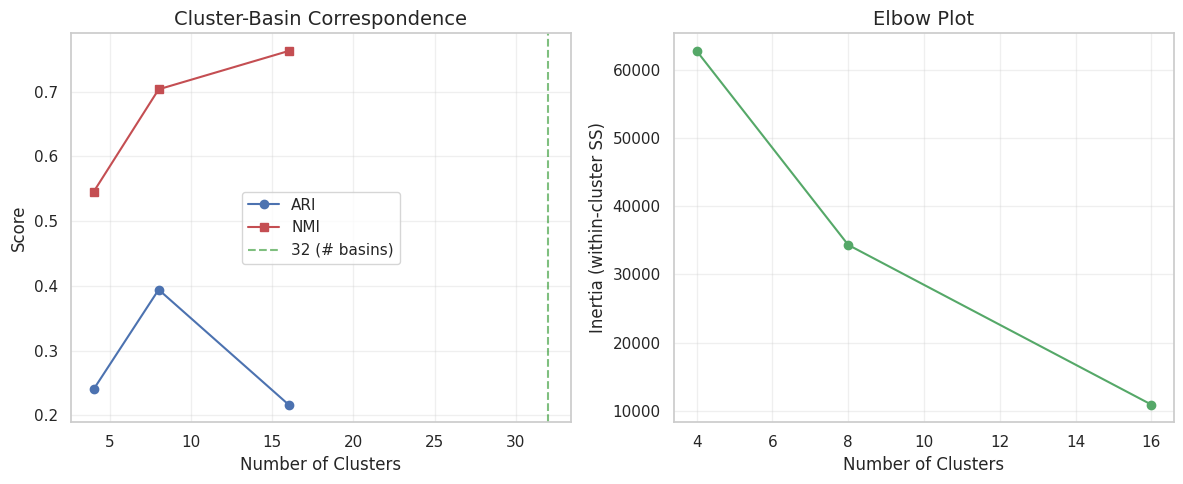

In [9]:
# Plot clustering quality
if len(cluster_df) > 0:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 5))

    ax1.plot(cluster_df['n_clusters'], cluster_df['ARI'], 'b-o', label='ARI')
    ax1.plot(cluster_df['n_clusters'], cluster_df['NMI'], 'r-s', label='NMI')
    ax1.axvline(x=32, color='green', linestyle='--', alpha=0.5, label='32 (# basins)')
    ax1.set_xlabel('Number of Clusters', fontsize=12)
    ax1.set_ylabel('Score', fontsize=12)
    ax1.set_title('Cluster-Basin Correspondence', fontsize=14)
    ax1.legend()
    ax1.grid(True, alpha=0.3)

    ax2.plot(cluster_df['n_clusters'], cluster_df['inertia'], 'g-o')
    ax2.set_xlabel('Number of Clusters', fontsize=12)
    ax2.set_ylabel('Inertia (within-cluster SS)', fontsize=12)
    ax2.set_title('Elbow Plot', fontsize=14)
    ax2.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('../../results/figures/09b_clustering.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Skipping clustering plot (not enough samples)")

## Analysis 3: UMAP Visualization

In [10]:
try:
    import umap
    HAS_UMAP = True
except ImportError:
    HAS_UMAP = False
    print("UMAP not installed, skipping manifold visualization")

if HAS_UMAP:
    # UMAP embedding
    reducer = umap.UMAP(n_components=2, random_state=42, n_neighbors=15, min_dist=0.1)
    embedding = reducer.fit_transform(X)
    
    print(f"UMAP embedding shape: {embedding.shape}")

UMAP not installed, skipping manifold visualization


In [11]:
if HAS_UMAP:
    fig, ax = plt.subplots(figsize=(12, 10))
    
    # Color by basin ID
    scatter = ax.scatter(embedding[:, 0], embedding[:, 1], 
                        c=basin_ids, cmap='tab20', alpha=0.6, s=20)
    
    ax.set_xlabel('UMAP 1', fontsize=12)
    ax.set_ylabel('UMAP 2', fontsize=12)
    ax.set_title('UMAP of V-Trajectories (colored by Basin ID)', fontsize=14)
    
    # Colorbar
    cbar = plt.colorbar(scatter, ax=ax)
    cbar.set_label('Basin ID')
    
    plt.tight_layout()
    plt.savefig('../../results/figures/09b_umap.png', dpi=150, bbox_inches='tight')
    plt.show()
else:
    print("Skipping UMAP plot")

Skipping UMAP plot


## Summary Statistics

In [12]:
# Create summary table
lb_dim_10 = lb_df[lb_df['k']==10]['mean_dim'].values[0] if (len(lb_df) > 0 and 10 in lb_df['k'].values) else np.nan
ari_32 = cluster_df[cluster_df['n_clusters']==32]['ARI'].values[0] if (len(cluster_df) > 0 and 32 in cluster_df['n_clusters'].values) else np.nan
nmi_32 = cluster_df[cluster_df['n_clusters']==32]['NMI'].values[0] if (len(cluster_df) > 0 and 32 in cluster_df['n_clusters'].values) else np.nan

summary = {
    'metric': [
        'Total paths analyzed',
        'Unique basins observed',
        'PCA dim for 90% variance',
        'PCA dim for 95% variance',
        'Levina-Bickel dim (k=10)',
        'K-means ARI (k=32)',
        'K-means NMI (k=32)',
    ],
    'value': [
        len(path_data),
        len(np.unique(basin_ids)),
        dim_90,
        dim_95,
        f"{lb_dim_10:.2f}" if not np.isnan(lb_dim_10) else "N/A",
        f"{ari_32:.3f}" if not np.isnan(ari_32) else "N/A",
        f"{nmi_32:.3f}" if not np.isnan(nmi_32) else "N/A",
    ]
}

summary_df = pd.DataFrame(summary)
print(summary_df.to_string(index=False))

summary_df.to_csv('../../results/tables/09b_geometry.csv', index=False)
print("\nSaved to results/tables/09b_geometry.csv")

                  metric value
    Total paths analyzed    30
  Unique basins observed    14
PCA dim for 90% variance     2
PCA dim for 95% variance     5
Levina-Bickel dim (k=10)  3.04
      K-means ARI (k=32)   N/A
      K-means NMI (k=32)   N/A

Saved to results/tables/09b_geometry.csv


## Conclusion

In [13]:
print("=" * 60)
print("CONCLUSION: Is intrinsic dimension ≈ 5?")
print("=" * 60)

if len(path_data) < 10:
    print(f"\n INSUFFICIENT DATA - Only {len(path_data)} paths collected")
    print("\nNeed more data to draw conclusions.")
elif dim_95 <= 7:
    print(f"\n YES - PCA 95% dimension = {dim_95}")
    print("\nThe path space has low intrinsic dimension.")
    print("Count capture outcomes (5 binary variables) largely explain path structure.")
elif dim_95 <= 15:
    print(f"\n PARTIALLY - PCA 95% dimension = {dim_95}")
    print("\nPath space has moderate dimension.")
    print("Count capture matters but there's additional structure.")
else:
    print(f"\n NO - PCA 95% dimension = {dim_95}")
    print("\nPath space is high-dimensional.")
    print("Count capture alone doesn't explain path structure.")

# Clustering interpretation
if len(cluster_df) > 0:
    best_ari = cluster_df['ARI'].max()
    if best_ari > 0.5:
        print(f"\nClustering strongly aligns with basins (ARI={best_ari:.3f}).")
    elif best_ari > 0.2:
        print(f"\nClustering moderately aligns with basins (ARI={best_ari:.3f}).")
    else:
        print(f"\nClustering poorly aligns with basins (ARI={best_ari:.3f}).")

print("\n" + "=" * 60)

CONCLUSION: Is intrinsic dimension ≈ 5?

 YES - PCA 95% dimension = 5

The path space has low intrinsic dimension.
Count capture outcomes (5 binary variables) largely explain path structure.

Clustering moderately aligns with basins (ARI=0.394).

